In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

from scipy.interpolate import interp1d

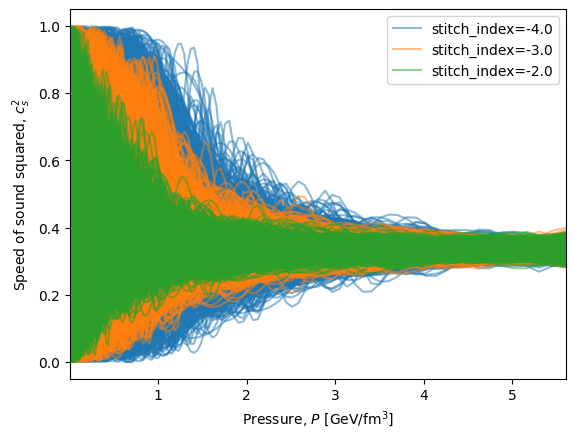

In [2]:
# Campaign numbers to compare
sets = [2, 0, 1]

# Campaign descriptions
set_keys = {
    0: 'stitch_index=-3.0',
    1: 'stitch_index=-2.0',
    2: 'stitch_index=-4.0',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend()

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

In [3]:
X_boundaries = [0.5, 2]
mu_boundaries = [2.4, 2.6]

array_resolution = 100
X_array = np.linspace(*X_boundaries, array_resolution)
mu_array = np.linspace(*mu_boundaries, array_resolution)

p_boundary_arrays = []
n_boundary_arrays = []

# Get the fixed-mu arrays first
for mu in mu_boundaries:
    p_boundary_arrays.append(np.zeros(array_resolution))
    n_boundary_arrays.append(np.zeros(array_resolution))
    for i, X in enumerate(X_array):
        pQCDX = pqcd.pQCD(X)
        p_boundary_arrays[-1][i] = pQCDX.pH(mu)
        n_boundary_arrays[-1][i] = pQCDX.nH(mu)

# Get the fixed-X arrays next
for X in X_boundaries:
    p_boundary_arrays.append(np.zeros(array_resolution))
    n_boundary_arrays.append(np.zeros(array_resolution))
    for i, mu in enumerate(mu_array):
        pQCDX = pqcd.pQCD(X)
        p_boundary_arrays[-1][i] = pQCDX.pH(mu)
        n_boundary_arrays[-1][i] = pQCDX.nH(mu)

In [4]:
left_n_boundary = np.hstack([n_boundary_arrays[0], n_boundary_arrays[3]])
right_n_boundary = np.hstack([n_boundary_arrays[2], n_boundary_arrays[1]])

left_p_boundary = np.hstack([p_boundary_arrays[0], p_boundary_arrays[3]])
right_p_boundary = np.hstack([p_boundary_arrays[2], p_boundary_arrays[1]])

n_boundary_min = min(left_n_boundary)
n_boundary_max = max(right_n_boundary)

p_boundary_min = min(left_p_boundary)
p_boundary_max = max(right_p_boundary)

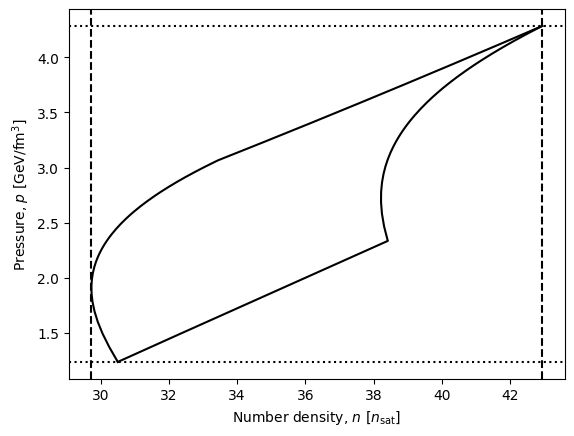

In [5]:
fig, ax = plt.subplots()

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-')
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-')

ax.axvline(n_boundary_min/nsat, color='k', ls='--')
ax.axvline(n_boundary_max/nsat, color='k', ls='--')

ax.axhline(p_boundary_min, color='k', ls=':')
ax.axhline(p_boundary_max, color='k', ls=':')

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [6]:
X_boundaries = [0.5, 2]
mu_boundaries = [2.4, 2.6]

array_resolution = 100
X_array = np.linspace(*X_boundaries, array_resolution)
mu_array = np.linspace(*mu_boundaries, array_resolution)

p_boundary_arrays = []
n_boundary_arrays = []

# Generate a dense grid of fixed-X arrays 
dense_arrays = {}
for mu in mu_array:
    dense_p_array = []
    dense_n_array = []
    for X in X_array:
        pQCDX = pqcd.pQCD(X)
        dense_p_array.append(pQCDX.pH(mu))
        dense_n_array.append(pQCDX.nH(mu))
    dense_arrays[mu] = (dense_p_array, dense_n_array)

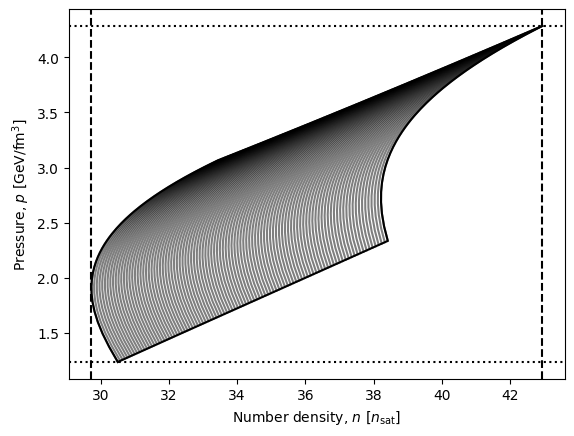

In [7]:
fig, ax = plt.subplots()

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-')
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-')

for mu in mu_array:
    dense_p_array, dense_n_array = dense_arrays[mu]
    ax.plot(np.array(dense_n_array)/nsat, np.array(dense_p_array), 'k', alpha=0.5)

ax.axvline(n_boundary_min/nsat, color='k', ls='--')
ax.axvline(n_boundary_max/nsat, color='k', ls='--')

ax.axhline(p_boundary_min, color='k', ls=':')
ax.axhline(p_boundary_max, color='k', ls=':')

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

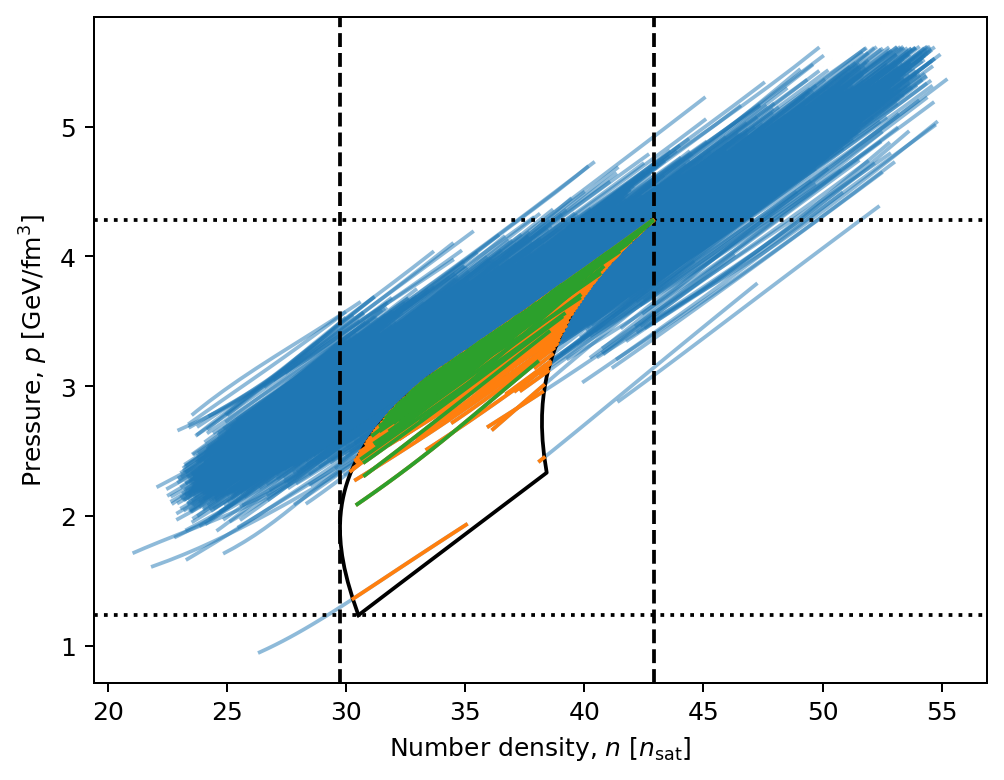

In [9]:
# Number of EOS draws
N_samp = 1000

good_EOSs = {s: [] for s in sets}

chemical_potential_array = np.linspace(2.4, 2.6, 100)

fig, ax = plt.subplots(dpi=180)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

for s in sets:

    for variety in ['had', 'hyp', 'qrk']:

        for ni in range(N_samp):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density

            # Build an interpolant over chemical potential
            pressure_interp = interp1d(chemical_potential, pressure, bounds_error=False)(chemical_potential_array)
            energy_density_interp = interp1d(chemical_potential, energy_density, bounds_error=False)(chemical_potential_array)
            number_density_interp = interp1d(chemical_potential, number_density, bounds_error=False)(chemical_potential_array)

            # Perform a quick filter to remove EOSs that don't cross the min and max number densities
            if max(number_density_interp) < n_boundary_min or min(number_density_interp) > n_boundary_max:
                continue

            # Perform a quick filter to remove EOSs that don't cross the min and max pressures
            if max(pressure_interp) < p_boundary_min or min(pressure_interp) > p_boundary_max:
                continue

            ax.plot(number_density_interp/nsat, pressure_interp, alpha=0.5, c='C0')

            inside_region_n = []
            inside_region_p = []
            inside_region_mu = []

            for n, p, mu in zip(number_density_interp, pressure_interp, chemical_potential_array):
                if p_boundary_min < p < p_boundary_max:
                    min_n = left_n_boundary[np.argmin(np.abs(left_p_boundary-p))]
                    max_n = right_n_boundary[np.argmin(np.abs(right_p_boundary-p))]
                    if n > min_n and n < max_n:
                        inside_region_n.append(n)
                        inside_region_p.append(p)
                        inside_region_mu.append(mu)
            
            if len(inside_region_n) > 0:

                inside_region_n = np.array(inside_region_n)
                inside_region_p = np.array(inside_region_p)
                inside_region_mu = np.array(inside_region_mu)

                ax.plot(inside_region_n/nsat, inside_region_p, 'C1', zorder=5)

                mu_start = min(inside_region_mu)
                mu_end = max(inside_region_mu)

                # Given the start and end values of mu for the EOS inside
                # the region, we want to see if the EOS passes through the
                # surface defined by the region. Assuming the EOS only 
                # crosses the surface once, we can simply check if the EOS 
                # starts above the surface and ends below it, or vice 
                # versa.

                # If the projection of the EOS onto the n-p plane is 
                # contained completely within the pQCD region, then it must
                # cross the surface at least once (I think...)
                if (mu_start > 2.4) and (mu_end < 2.6):
                    good_EOSs[s].append((variety, ni))
                    ax.plot(inside_region_n/nsat, inside_region_p, 'C2', zorder=10)

                # Otherwise, we project the start and end points of the EOS
                # onto the surface and check if they are on opposite sides
                # of the surface. If they are, then the EOS must cross the
                # surface at least once.
                else:

                    n_start = inside_region_n[np.argmin(inside_region_mu)]
                    p_start = inside_region_p[np.argmin(inside_region_mu)]

                    min_delta = 1
                    for mu, (dense_p_array, dense_n_array) in dense_arrays.items():
                        delta = abs(n_start - dense_n_array[np.argmin(np.abs(dense_p_array-p_start))])
                        if delta < min_delta:
                            min_delta = delta
                            mu_start_projected = mu

                    n_end = inside_region_n[np.argmax(inside_region_mu)]
                    p_end = inside_region_p[np.argmax(inside_region_mu)]

                    min_delta = 1
                    for mu, (dense_p_array, dense_n_array) in dense_arrays.items():
                        delta = abs(n_end - dense_n_array[np.argmin(np.abs(dense_p_array-p_end))])
                        if delta < min_delta:
                            min_delta = delta
                            mu_end_projected = mu

                    # EOS starts above the surface and ends below it
                    if (mu_start > mu_start_projected) and (mu_end < mu_end_projected):
                        good_EOSs[s].append((variety, ni))
                        ax.plot(inside_region_n/nsat, inside_region_p, 'C2', zorder=10)

                    # EOS starts below the surface and ends above it
                    elif (mu_start < mu_start_projected) and (mu_end > mu_end_projected):
                        good_EOSs[s].append((variety, ni))
                        ax.plot(inside_region_n/nsat, inside_region_p, 'C2', zorder=10)

                # The above does not consider the case of the EOS crossing 
                # the surface an even number of times...

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-')
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-')

ax.axvline(n_boundary_min/nsat, color='k', ls='--')
ax.axvline(n_boundary_max/nsat, color='k', ls='--')

ax.axhline(p_boundary_min, color='k', ls=':')
_ = ax.axhline(p_boundary_max, color='k', ls=':')

In [12]:
for s in sets:
    print(f'{set_keys[s]}: {len(good_EOSs[s])}')

stitch_index=-4.0: 29
stitch_index=-3.0: 30
stitch_index=-2.0: 28


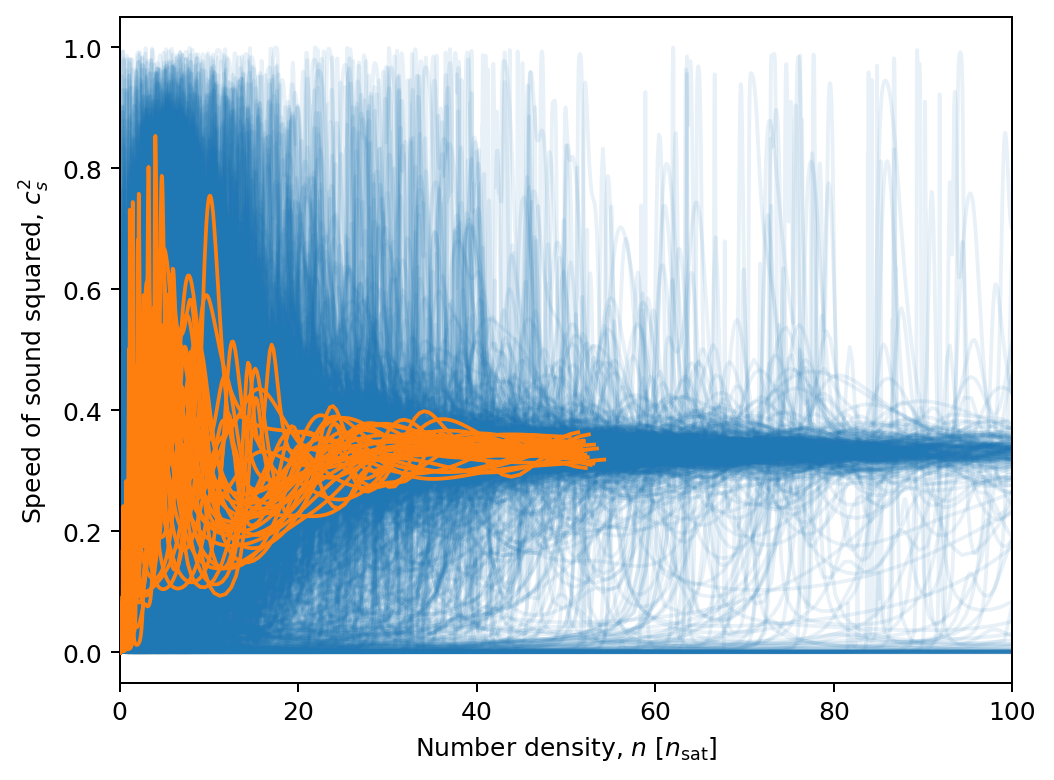

In [15]:
# Number of EOS draws
N_samp = 1000

fig, ax = plt.subplots(dpi=180)

for s in [0]:

    for variety in ['had', 'hyp', 'qrk']:

        for ni in range(N_samp):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(number_density/nsat, speed_of_sound_squared, alpha=0.1, c='C0')

            if (variety, ni) in good_EOSs[s]:
                ax.plot(number_density/nsat, speed_of_sound_squared, 'C1', zorder=5)

ax.set_xlim(0, 100)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

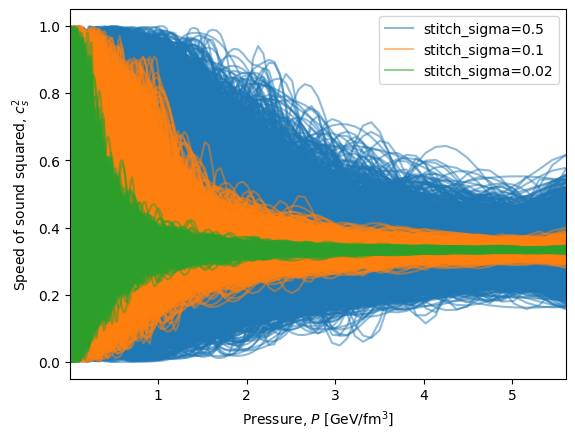

In [16]:
# Campaign numbers to compare
sets = [3, 0, 4]

# Campaign descriptions
set_keys = {
    4: 'stitch_sigma=0.02',
    0: 'stitch_sigma=0.1',
    3: 'stitch_sigma=0.5',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend()

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

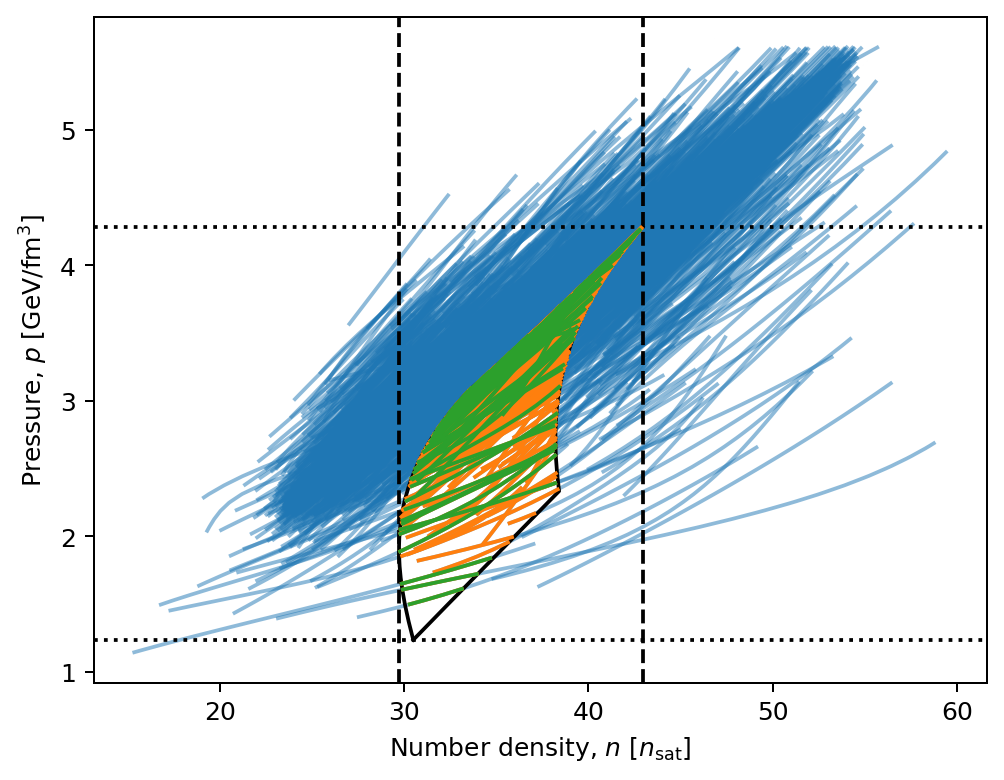

In [17]:
# Number of EOS draws
N_samp = 1000

good_EOSs = {s: [] for s in sets}

chemical_potential_array = np.linspace(2.4, 2.6, 100)

fig, ax = plt.subplots(dpi=180)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

for s in sets:

    for variety in ['had', 'hyp', 'qrk']:

        for ni in range(N_samp):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density

            # Build an interpolant over chemical potential
            pressure_interp = interp1d(chemical_potential, pressure, bounds_error=False)(chemical_potential_array)
            energy_density_interp = interp1d(chemical_potential, energy_density, bounds_error=False)(chemical_potential_array)
            number_density_interp = interp1d(chemical_potential, number_density, bounds_error=False)(chemical_potential_array)

            # Perform a quick filter to remove EOSs that don't cross the min and max number densities
            if max(number_density_interp) < n_boundary_min or min(number_density_interp) > n_boundary_max:
                continue

            # Perform a quick filter to remove EOSs that don't cross the min and max pressures
            if max(pressure_interp) < p_boundary_min or min(pressure_interp) > p_boundary_max:
                continue

            ax.plot(number_density_interp/nsat, pressure_interp, alpha=0.5, c='C0')

            inside_region_n = []
            inside_region_p = []
            inside_region_mu = []

            for n, p, mu in zip(number_density_interp, pressure_interp, chemical_potential_array):
                if p_boundary_min < p < p_boundary_max:
                    min_n = left_n_boundary[np.argmin(np.abs(left_p_boundary-p))]
                    max_n = right_n_boundary[np.argmin(np.abs(right_p_boundary-p))]
                    if n > min_n and n < max_n:
                        inside_region_n.append(n)
                        inside_region_p.append(p)
                        inside_region_mu.append(mu)
            
            if len(inside_region_n) > 0:

                inside_region_n = np.array(inside_region_n)
                inside_region_p = np.array(inside_region_p)
                inside_region_mu = np.array(inside_region_mu)

                ax.plot(inside_region_n/nsat, inside_region_p, 'C1', zorder=5)

                mu_start = min(inside_region_mu)
                mu_end = max(inside_region_mu)

                # Given the start and end values of mu for the EOS inside
                # the region, we want to see if the EOS passes through the
                # surface defined by the region. Assuming the EOS only 
                # crosses the surface once, we can simply check if the EOS 
                # starts above the surface and ends below it, or vice 
                # versa.

                # If the projection of the EOS onto the n-p plane is 
                # contained completely within the pQCD region, then it must
                # cross the surface at least once (I think...)
                if (mu_start > 2.4) and (mu_end < 2.6):
                    good_EOSs[s].append((variety, ni))
                    ax.plot(inside_region_n/nsat, inside_region_p, 'C2', zorder=10)

                # Otherwise, we project the start and end points of the EOS
                # onto the surface and check if they are on opposite sides
                # of the surface. If they are, then the EOS must cross the
                # surface at least once.
                else:

                    n_start = inside_region_n[np.argmin(inside_region_mu)]
                    p_start = inside_region_p[np.argmin(inside_region_mu)]

                    min_delta = 1
                    for mu, (dense_p_array, dense_n_array) in dense_arrays.items():
                        delta = abs(n_start - dense_n_array[np.argmin(np.abs(dense_p_array-p_start))])
                        if delta < min_delta:
                            min_delta = delta
                            mu_start_projected = mu

                    n_end = inside_region_n[np.argmax(inside_region_mu)]
                    p_end = inside_region_p[np.argmax(inside_region_mu)]

                    min_delta = 1
                    for mu, (dense_p_array, dense_n_array) in dense_arrays.items():
                        delta = abs(n_end - dense_n_array[np.argmin(np.abs(dense_p_array-p_end))])
                        if delta < min_delta:
                            min_delta = delta
                            mu_end_projected = mu

                    # EOS starts above the surface and ends below it
                    if (mu_start > mu_start_projected) and (mu_end < mu_end_projected):
                        good_EOSs[s].append((variety, ni))
                        ax.plot(inside_region_n/nsat, inside_region_p, 'C2', zorder=10)

                    # EOS starts below the surface and ends above it
                    elif (mu_start < mu_start_projected) and (mu_end > mu_end_projected):
                        good_EOSs[s].append((variety, ni))
                        ax.plot(inside_region_n/nsat, inside_region_p, 'C2', zorder=10)

                # The above does not consider the case of the EOS crossing 
                # the surface an even number of times...

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-')
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-')

ax.axvline(n_boundary_min/nsat, color='k', ls='--')
ax.axvline(n_boundary_max/nsat, color='k', ls='--')

ax.axhline(p_boundary_min, color='k', ls=':')
_ = ax.axhline(p_boundary_max, color='k', ls=':')

In [18]:
for s in sets:
    print(f'{set_keys[s]}: {len(good_EOSs[s])}')

stitch_sigma=0.5: 45
stitch_sigma=0.1: 30
stitch_sigma=0.02: 10


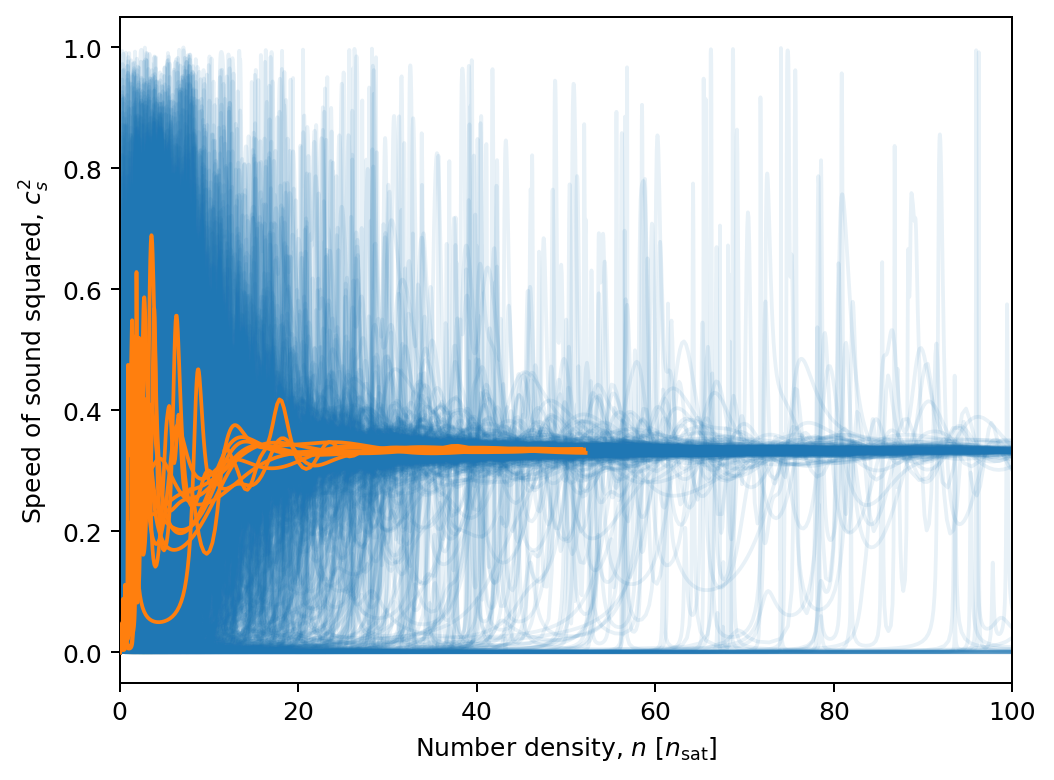

In [19]:
# Number of EOS draws
N_samp = 1000

fig, ax = plt.subplots(dpi=180)

for s in [4]:

    for variety in ['had', 'hyp', 'qrk']:

        for ni in range(N_samp):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(number_density/nsat, speed_of_sound_squared, alpha=0.1, c='C0')

            if (variety, ni) in good_EOSs[s]:
                ax.plot(number_density/nsat, speed_of_sound_squared, 'C1', zorder=5)

ax.set_xlim(0, 100)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')